In [1]:
import sys
sys.path.append("/Users/coffee/Documents/code/QkidsAutomation")
from qkids.DatabasePool import get_odps
odps = get_odps()
from odps import DataFrame
import pandas as pd

In [2]:
opds_df = DataFrame(odps.get_table("dwd_teacher_tiemtable_stat_w"))

# 老师请假情况

In [26]:
df = opds_df[(opds_df.week_id > '202000') & (opds_df.week_id < '202009') & (opds_df.available_cnt > 0)].to_pandas()
df = df.fillna(0)

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

老师202001周到202009周的缺席情况：

In [40]:
for week_id, data in df.groupby('week_id'):
    teacher_cnt = len(data)
    finish = data.finish.sum()
    absent = data.absent.sum()
    accident = data.accident.sum()
    print(f"week {week_id}: teacher {teacher_cnt} finish {finish} absent {absent} ({round(absent/finish, 3)}) accident {accident} ({round(accident/finish,3)})")

week 202001: teacher 3706 finish 23633.0 absent 2321.0 (0.098) accident 1421.0 (0.06)
week 202002: teacher 4099 finish 29364.0 absent 2510.0 (0.085) accident 1169.0 (0.04)
week 202003: teacher 4225 finish 42159.0 absent 3408.0 (0.081) accident 1537.0 (0.036)
week 202004: teacher 5257 finish 34539.0 absent 3496.0 (0.101) accident 1121.0 (0.032)
week 202005: teacher 5101 finish 56732.0 absent 4814.0 (0.085) accident 2286.0 (0.04)
week 202006: teacher 3478 finish 60906.0 absent 5284.0 (0.087) accident 2737.0 (0.045)
week 202007: teacher 3175 finish 48859.0 absent 5367.0 (0.11) accident 2550.0 (0.052)
week 202008: teacher 2699 finish 9706.0 absent 844.0 (0.087) accident 512.0 (0.053)


老师的每周老师的缺席平均率 和 这几周的总缺席平均率：

In [41]:
present_tewacher = df.loc[df.finish + df.absent + df.accident > 0]

In [46]:
output = []
for week_id, data in present_tewacher.groupby('week_id'):
    s = (data.absent + data.accident) / (data.absent + data.accident + data.finish)
    print(f"week {week_id}: teacher absent rate mean: {s.mean()}")
    output.append(s.mean())
print(f"[teacher mean]: {sum(output) / len(output)}")

week 202001: teacher absent rate mean: 0.22550071969308355
week 202002: teacher absent rate mean: 0.1894600130122006
week 202003: teacher absent rate mean: 0.1736850951900111
week 202004: teacher absent rate mean: 0.16477182544575972
week 202005: teacher absent rate mean: 0.16511985304581173
week 202006: teacher absent rate mean: 0.18276706821730873
week 202007: teacher absent rate mean: 0.20731544687664255
week 202008: teacher absent rate mean: 0.16143223133879814
[teacher mean]: 0.18375653160245203


老师每周缺席率（10%），和上课的缺席率（18%）差距颇大 。查看一下出勤率的频率：

In [48]:
s = (present_tewacher.absent + present_tewacher.accident) / (present_tewacher.absent + present_tewacher.accident + present_tewacher.finish)

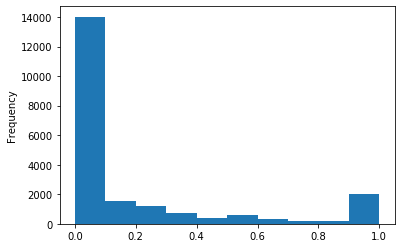

In [53]:
s.plot(kind='hist')

大部分老师表现都特别好， 只有少部分老师几乎100%缺席拉高了请假率

In [54]:
s.describe()

count    21193.000000
mean         0.181721
std          0.314758
min          0.000000
25%          0.000000
50%          0.000000
75%          0.214286
max          1.000000
dtype: float64

中位数位0， 75%位为0.21，我觉得可以设定0.21的请假率可以合理。不进行排课处罚， 边儿只对剩下的25%的老师请假比例超过0.21的老师进行处罚

### 老师无故缺席情况

老师的每周老师的无故缺席平均率 和 这几周的总无故缺席平均率：

In [55]:
output = []
for week_id, data in present_tewacher.groupby('week_id'):
    s = data.accident / (data.absent + data.accident + data.finish)
    print(f"week {week_id}: teacher absent rate mean: {s.mean()}")
    output.append(s.mean())
print(f"[teacher mean]: {sum(output) / len(output)}")

week 202001: teacher absent rate mean: 0.08864660088778818
week 202002: teacher absent rate mean: 0.0678684894292612
week 202003: teacher absent rate mean: 0.06305587895243277
week 202004: teacher absent rate mean: 0.05075867913675793
week 202005: teacher absent rate mean: 0.06113756624814855
week 202006: teacher absent rate mean: 0.07981055022164825
week 202007: teacher absent rate mean: 0.08591998383940977
week 202008: teacher absent rate mean: 0.06568059861285264
[teacher mean]: 0.0703597934160374


老师每周无故缺席率（7%），和上课的无故缺席率（5%）有出入 。查看一下无故出勤率的频率：

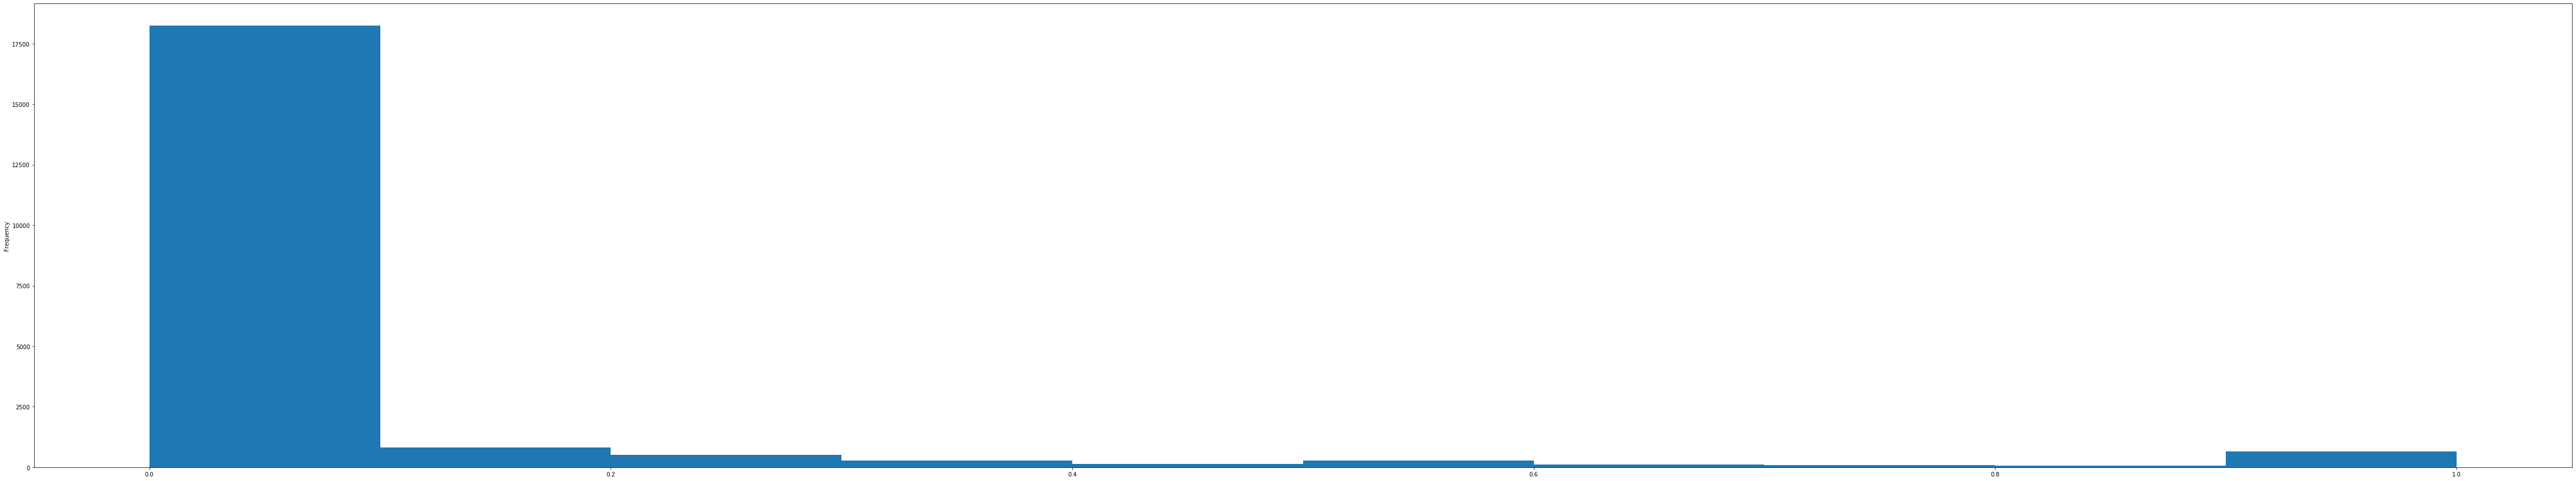

In [57]:
s = ( present_tewacher.accident) / (present_tewacher.absent + present_tewacher.accident + present_tewacher.finish)
s.plot(kind='hist', figsize = (80, 15))

依然是部分老师出勤较差，影响的总体水平，建议处理方法同普通缺席一样

In [60]:
len(s.loc[s>0]) / len(s)

0.19360166092577738

有19%的老师有无故缺席，建议有无故缺席的就进行排课处罚（按出勤比例排课）。

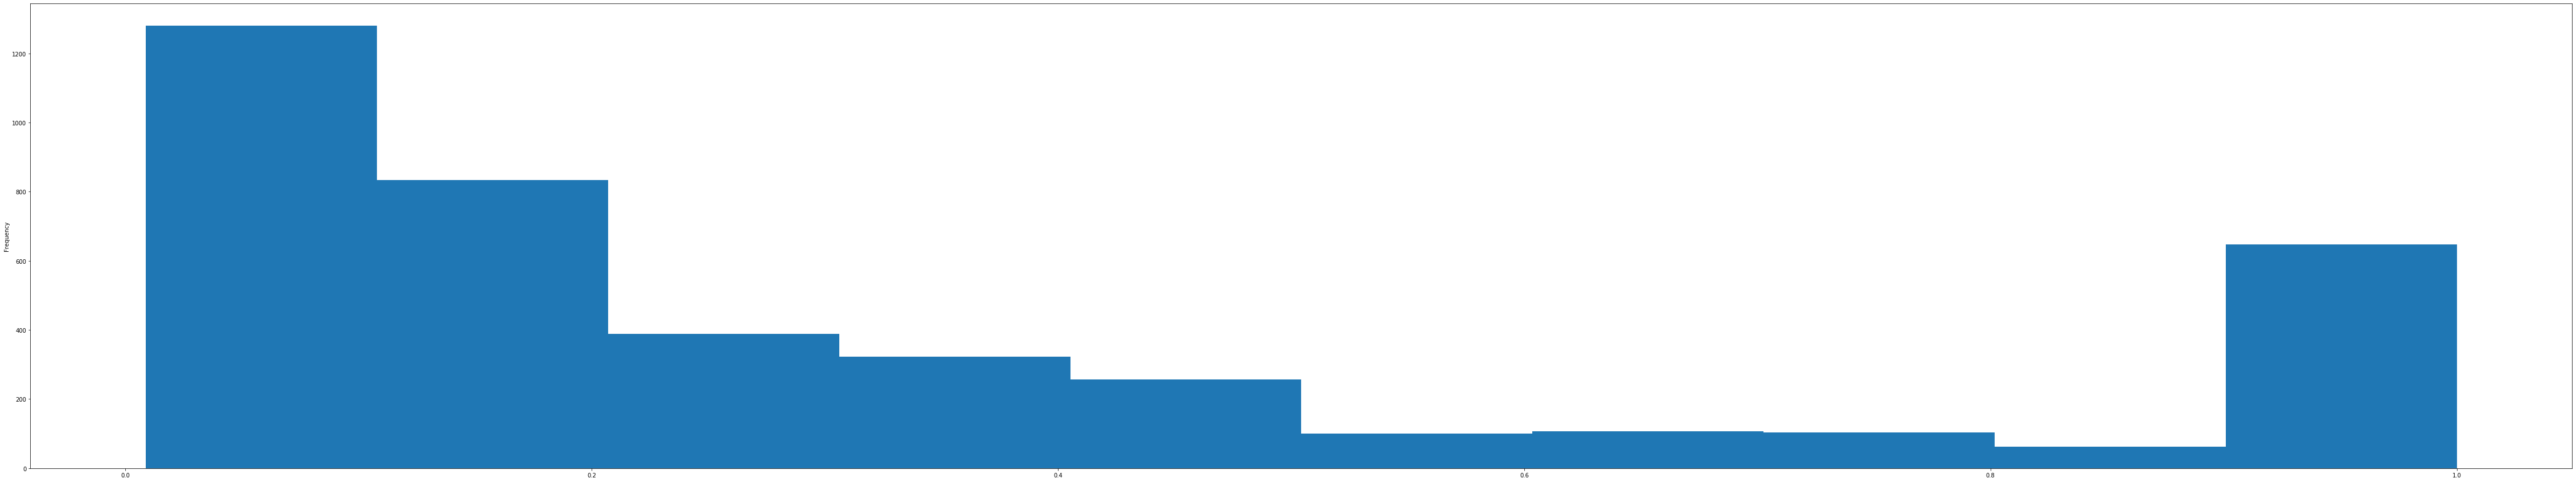

In [61]:
s.loc[s>0].plot(kind='hist', figsize = (80, 15))

In [66]:
s.loc[s>0].describe()

count    4103.000000
mean        0.351893
std         0.338464
min         0.008772
25%         0.083333
50%         0.200000
75%         0.500000
max         1.000000
dtype: float64

在这有无故缺席的19%老师中， 其中一半老师无故缺席率在20%以下， 建议以无故缺席率为20%为阈值，对于高于这个数值的老师进行处罚。

这19%的老师的无故缺席频率

）问题：这里的缺席是否有异常数据（比如standby替换以后，发现他是没来。如果有这中数量是多少，是否应该不算无故缺席

### 请假时分析
查看老师多少久开始请假

In [3]:
teacher_appointments = DataFrame(odps.get_table("ods_teacher_appointments").get_partition('ds=20200402'))

In [4]:
teacher_appointments.head(10)

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

DFViewWidget()

,id,teacher_id,schedule_id,room_id,status,is_watching,performance_bonus,join_room_at,leave_room_at,created_at,updated_at,remark,tag,klass_id,online_time,class_time,teacher_remark,traced,ip
0,1,1,14,29,1,0,0,None,None,2017-06-01 16:18:52,2019-04-08 19:00:22,trttte,3,None,None,None,None,0,None
1,3,1,16,32,0,0,0,None,None,2017-06-05 14:27:11,2019-04-08 19:00:36,None,0,None,None,None,None,0,None
2,5,1,18,35,0,0,0,None,None,2017-06-08 09:32:16,2017-06-08 09:32:16,None,0,None,None,None,None,0,None
3,6,1,33,50,0,0,0,None,None,2017-06-19 15:03:50,2017-06-19 15:03:50,None,0,None,None,None,None,0,None
4,11,1,39,56,0,0,0,None,None,2017-06-20 12:01:04,2017-06-20 12:01:04,None,0,None,None,None,None,0,None
5,12,1,41,58,0,0,0,None,None,2017-06-21 10:11:06,2017-06-21 10:11:06,None,0,None,None,None,None,0,None
6,21,1682,54,71,0,0,0,None,None,2017-06-23 14:53:15,2017-06-23 14:53:15,None,0,None,None,None,None,0,None
7,23,1682,55,72,0,0,0,None,None,2017-06-23 14:53:40,2017-06-23 14:53:40,None,0,None,None,None,None,0,None
8,26,1682,59,76,0,0,0,None,None,2017-06-23 14:56:59,2017-06-23 14:56:59,None,0,None,None,None,None,0,None
9,29,1682,63,80,0,0,0,None,None,2017-06-23 14:57:15,2017-06-23 14:57:15,None,0,None,None,None,None,0,None


In [2]:
teacher_absent = pd.read_pickle('teacher_absent_rate_each_slot.pkl')

In [3]:
teacher_absent

,14,59,62,70,72,81,125,149,165,208,...,437285,437448,437465,437580,437795,437801,437919,438523,438611,440922
1_07:50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_08:30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_09:10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_09:50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1_10:30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_17:50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_18:30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_19:10,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_19:50,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
